In [1]:
from src.mitnanex import run
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

In [2]:

clusters_list = run()

# I need to plot the coverage of clusters
coverages_df = pd.DataFrame(
    {
        "coverage": [i.coverage for i in clusters_list.clusters],
        "repr_read_len": [i.longest_read_length for i in clusters_list.clusters],
        "id_longest_read": [i.longest_read_id for i in clusters_list.clusters],
        "id_cluster":[i.id_cluster for i in clusters_list.clusters],
    }
)

In [3]:
# Test on the first 30 clusters
import math
clusters = coverages_df.sort_values(by='coverage', ascending=False)
clusters.sort_values(by='id_longest_read',inplace=True)
clusters.head()

,coverage,repr_read_len,id_longest_read,id_cluster
3726,2,1839,000affec-9039-447a-9580-c3da44789396,3727
103,14,14491,001c7766-b26e-4d28-935d-2b6cddc15cab,104
5182,2,635,001d5636-2de4-4371-9cf0-501936637b77,5183
396,16,8508,001dc81d-06ca-4174-a53d-6e82b1dff234,397
3134,2,2251,002369ac-2721-428e-a29c-712bebd71001,3135


# Coverage

The first step is to filter the reads by coverage. For that I will explore the use of Kernel Density since this is clusters_list one dimensional clustering.

In [4]:
clusters['transform'] = [math.log2(i)for i in clusters['coverage']]
clusters.sort_values('coverage',ascending=False, inplace=True)
clusters.head()

,coverage,repr_read_len,id_longest_read,id_cluster,transform
10,705,30009,31d41fce-9796-442d-ac9e-0e8951545241,11,9.461479
49,638,19448,2a5d92c9-a665-47d6-83cf-52296c617f46,50,9.317413
63,426,17368,323a391b-0c08-46bd-bc32-26ecbadfed9f,64,8.734710
116,167,13931,2817a84c-62b7-4bfd-8d15-ea5c6f496363,117,7.383704
127,156,13396,7cf2b8b1-5b4f-4234-af33-39732ff36a8b,128,7.285402


<Axes: >

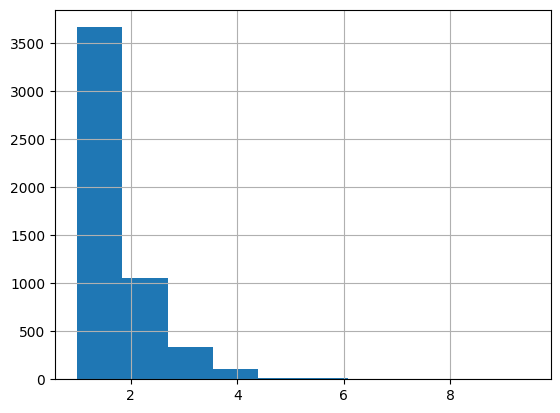

In [5]:
clusters['transform'].hist()

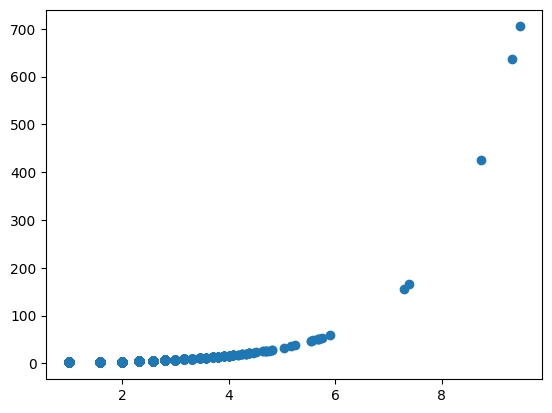

In [6]:
plt.scatter(x=clusters['transform'], y=clusters['coverage'])

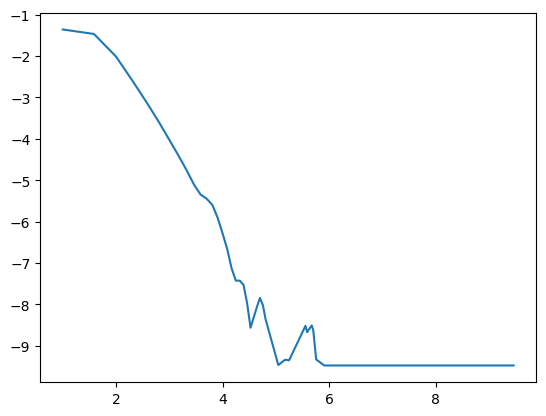

In [31]:
kde = KernelDensity(kernel='gaussian', bandwidth=1).fit(clusters['coverage'].array.reshape(-1,1))
cov_fdp = kde.score_samples(clusters['coverage'].array.reshape(-1,1))
plt.plot(clusters['transform'], cov_fdp)

In [8]:
from scipy.signal import argrelextrema
import numpy as np
local_min = argrelextrema(cov_fdp, np.less)[0]
min_coverage = clusters.iloc[max(local_min),:]['coverage']
print("Covertura minima admitida: ", min_coverage)

Covertura minima admitida:  23


# Oligo composition

Once I've detected the clusters with higher coverage, which I expect includes mitochondria and contamination, whether nuclear or external, I have to purify these groups. To do this I will use the oligo composition as it is used during metagenomics binning.

I will create clusters_list script to get the kmers. The kmer size will be 3 to solve two things: 1. Intrinsec error from Nanopore, 2 smaller set as possible (4**3 possible kmers). 

Finally, I will reduce dimensionality using PCA

In [9]:
from src.utils import get_sequences_by_id, convert_fq_to_fa, write_fasta
from src.kmer_cnt import count_kmer

In [10]:
convert_fq_to_fa('test/all_talaro_porechop_18_07_2023.sorted.fastq','test/all_talaro_porechop_18_07_2023.sorted.fasta')

172753 sequences converted to fasta


'test/all_talaro_porechop_18_07_2023.sorted.fasta'

In [11]:
fasta = 'test/all_talaro_porechop_18_07_2023.sorted.fasta'
repr_reads = [i for i in clusters['id_longest_read']]
hist = list()
for i in get_sequences_by_id(fasta, repr_reads):
    ids, seq = i
    hist.append([*count_kmer(k=3,seq=seq).values(),ids])

In [12]:
## Get the real mt sequences
with open('test/list_ids_reads_mt.txt','r') as handle_ids_mt:
    ids_mt = handle_ids_mt.read().splitlines()
    ids_mt = [i[1:] for i in ids_mt]

In [13]:
hist_df= pd.DataFrame(hist)
hist_df.rename(columns={hist_df.iloc[:,-1].name:'ids'}, inplace=True)
hist_df.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,ids
0,0.040250,0.040572,0.029725,0.035141,0.034202,0.040837,0.041013,0.032631,0.028462,0.023472,...,0.021725,0.031457,0.025204,0.040176,0.028976,0.025160,0.034466,0.026114,0.029006,3c5ff513-a26f-4ff8-92f1-4d80907a744e
1,0.042840,0.040117,0.030494,0.038091,0.035496,0.039400,0.037057,0.032056,0.029713,0.023889,...,0.018761,0.029692,0.024606,0.042861,0.027371,0.025936,0.033132,0.024332,0.029249,3ec4ad4f-fb20-4cac-8e33-b5cd283824d0
2,0.048262,0.050432,0.028471,0.040973,0.060221,0.036255,0.032269,0.027339,0.030924,0.022715,...,0.018800,0.025027,0.018965,0.037411,0.025499,0.025688,0.028730,0.023258,0.027928,cfdfe593-4ad6-4375-9e55-595f6bc1fcfa
3,0.036002,0.032772,0.028925,0.032525,0.027939,0.039529,0.035854,0.028777,0.027446,0.029813,...,0.029122,0.034030,0.026114,0.041329,0.031292,0.024930,0.032525,0.028629,0.035854,a4b4ef42-6e8f-45c7-841b-848888fe245f
4,0.041463,0.037525,0.029674,0.037851,0.033838,0.040761,0.036923,0.030527,0.028871,0.024657,...,0.024030,0.034239,0.028093,0.040735,0.029021,0.024582,0.033612,0.027040,0.030251,808d5863-7caa-4123-b730-d3ef49298f39


# Dimensionality reduction with PCA and clustering with k-means 

In [14]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [15]:
pca = PCA(n_components=2)
pca.fit(hist_df.iloc[:,:-2])

PCA(n_components=2)

In [16]:
## Components and variance explained 
pca.explained_variance_
#pca.components_

array([0.08665239, 0.01264278])

In [23]:
kmer_reduction = pca.fit_transform(hist_df.iloc[:,:-2])
kmer_reduction = pd.DataFrame(kmer_reduction, columns=['comp1', 'comp2'])

## merging the dataframe with ids and other relevant information
kmer_reduction ['ids'] = hist_df['ids']
kmer_reduction = kmer_reduction.merge(clusters, how='left', left_on='ids', right_on='id_longest_read')
kmer_reduction.drop(columns='id_longest_read', inplace=True)

## Annotate which reads are mitochondrial
kmer_reduction['mt'] = 32#(kmer_reduction['ids'].isin(ids_mt).astype(int) + 1) ** 5
kmer_reduction = kmer_reduction[kmer_reduction['coverage'] > min_coverage]
kmer_reduction

,comp1,comp2,ids,coverage,repr_read_len,id_cluster,transform,mt
0,-0.054690,0.004871,3c5ff513-a26f-4ff8-92f1-4d80907a744e,47,68127,1,5.554589,32
1,-0.057828,0.003642,3ec4ad4f-fb20-4cac-8e33-b5cd283824d0,51,47388,2,5.672425,32
2,-0.059066,-0.001130,cfdfe593-4ad6-4375-9e55-595f6bc1fcfa,47,42396,3,5.554589,32
3,-0.047089,0.011913,a4b4ef42-6e8f-45c7-841b-848888fe245f,51,40555,4,5.672425,32
4,-0.051130,0.003445,808d5863-7caa-4123-b730-d3ef49298f39,26,39869,5,4.700440,32
5,-0.056287,0.005827,f67db50a-6333-4c4f-8bd5-002a9e93816b,36,35405,6,5.169925,32
6,-0.058722,0.005696,e17b4826-acb9-4db7-b804-d9a1448f12a4,60,35116,7,5.906891,32
10,-0.080302,-0.034224,31d41fce-9796-442d-ac9e-0e8951545241,705,30009,11,9.461479,32
14,-0.061286,0.005424,0c6e0b17-cf7c-4c1a-a982-a79ea58d1ee3,38,26507,15,5.247928,32
15,-0.054648,0.007496,0761e3cc-4dcf-4843-850c-b56ffff31f7a,52,26235,16,5.700440,32


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'comp2')

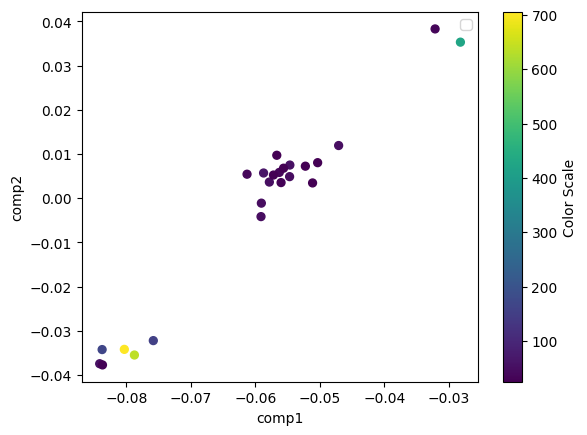

In [24]:
sc = plt.scatter(kmer_reduction['comp1'],kmer_reduction['comp2'], c=kmer_reduction['coverage'], s=kmer_reduction['mt'])
# legend
# Add clusters_list colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Color Scale')
plt.legend()
plt.xlabel('comp1')
plt.ylabel('comp2')

In [25]:
kmeans = KMeans(n_clusters=2, max_iter=100, init='k-means++', random_state=0, n_init=1,verbose=1)
mt_prediction = kmeans.fit_predict(kmer_reduction[['comp1','comp2']])#, sample_weight=kmer_reduction['coverage'])
kmer_reduction['cluster_prediction'] = mt_prediction

Initialization complete
Iteration 0, inertia 0.004171462009044572.
Iteration 1, inertia 0.0034359373083328146.
Converged at iteration 1: strict convergence.


Text(0, 0.5, 'comp2')

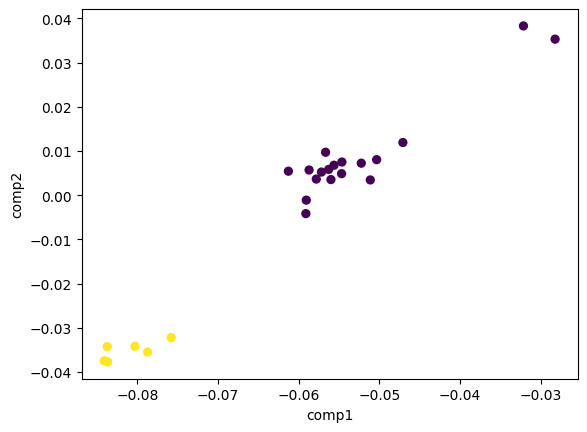

In [26]:
plt.scatter(x=kmer_reduction['comp1'], y=kmer_reduction['comp2'], c=mt_prediction, s=kmer_reduction['mt'])
plt.xlabel('comp1')
plt.ylabel('comp2')

# Get the cluster of interest

This step is clusters_list pain in the ass, but since I am looking to keep the free-reference. 

In [30]:
selected_cluster_id = kmer_reduction.loc[:, kmer_reduction.columns != 'ids'].groupby(by='cluster_prediction')['coverage'].median().idxmax()
selected_cluster = kmer_reduction[kmer_reduction['cluster_prediction'] == selected_cluster_id]
selected_cluster.sort_values('coverage')

,comp1,comp2,ids,coverage,repr_read_len,id_cluster,transform,mt,cluster_prediction
172,-0.083690,-0.037745,b3d5e0d0-52dd-4c0a-a094-fbca4e20f4eb,28,12084,173,4.807355,32,1
99,-0.084122,-0.037473,e41aa5a6-7aba-4e35-bfd5-10ed6dc38412,54,14678,100,5.754888,32,1
127,-0.075813,-0.032242,7cf2b8b1-5b4f-4234-af33-39732ff36a8b,156,13396,128,7.285402,32,1
116,-0.083745,-0.034269,2817a84c-62b7-4bfd-8d15-ea5c6f496363,167,13931,117,7.383704,32,1
49,-0.078741,-0.035502,2a5d92c9-a665-47d6-83cf-52296c617f46,638,19448,50,9.317413,32,1
10,-0.080302,-0.034224,31d41fce-9796-442d-ac9e-0e8951545241,705,30009,11,9.461479,32,1


In [28]:
sequences_ids = set()
for i in selected_cluster['id_cluster']:
    sequences_ids.update(clusters_list.get_cluster(i).id_sequences)
write_fasta(fasta=fasta, sequences_ids=sequences_ids, output='test/mt_reads_v1.fasta')

1748 reads retrieved
